In [25]:
import tensorflow as tf
import numpy as np

from tensorflow import keras
from tensorflow.keras.utils import to_categorical

from tensorflow.keras.models import Sequential
# from tensorflow.keras.utils import np_utils
from tensorflow.keras.layers import Dense, LSTM, Dropout
import tensorflow.keras.backend as K 
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import RMSprop

from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler


import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go

from math import sqrt

### 1. read file

1) 상대팀무시: lstm_data16.csv

In [26]:
data = pd.read_csv("lstm_data16.csv")
team = list(data.T_ID.unique())

data = pd.concat([data, pd.get_dummies(data.T_ID)], axis = 1)
# data.drop(["T_ID"], axis = 1, inplace = True)

In [27]:
train_data = data[data["IDX"] != 12]
test_data = data[data["IDX"] > 8]

In [28]:
train_data

,IDX,PCT,T_ID,HH,HT,KT,LG,LT,NC,OB,SK,SS,WO
0,1,0.166667,HH,1,0,0,0,0,0,0,0,0,0
1,2,0.416667,HH,1,0,0,0,0,0,0,0,0,0
2,3,0.166667,HH,1,0,0,0,0,0,0,0,0,0
3,4,0.636364,HH,1,0,0,0,0,0,0,0,0,0
4,5,0.666667,HH,1,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
114,7,0.833333,WO,0,0,0,0,0,0,0,0,0,1
115,8,0.500000,WO,0,0,0,0,0,0,0,0,0,1
116,9,0.583333,WO,0,0,0,0,0,0,0,0,0,1
117,10,0.666667,WO,0,0,0,0,0,0,0,0,0,1


###  2. shift window 생성

In [29]:
train_df = pd.DataFrame([])
for t in team:
    tmp_train = train_data[train_data["T_ID"]==t]
    for s in range(1, 4):
        tmp_train.loc[:,'shift_{}'.format(s)] = tmp_train.loc[:,'PCT'].shift(s)
    
    train_df = pd.concat([train_df, tmp_train], axis=0)
    
test_df = pd.DataFrame([])
for t in team:
    tmp_test = test_data[test_data["T_ID"]==t]
    for s in range(1, 4):
        tmp_test.loc[:,'shift_{}'.format(s)] = tmp_test.loc[:,'PCT'].shift(s)
    
    test_df = pd.concat([test_df, tmp_test], axis=0)


c:\users\julia\appdata\local\programs\python\python36\lib\site-packages\pandas\core\indexing.py:845: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

c:\users\julia\appdata\local\programs\python\python36\lib\site-packages\pandas\core\indexing.py:966: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [30]:
train_df

,IDX,PCT,T_ID,HH,HT,KT,LG,LT,NC,OB,SK,SS,WO,shift_1,shift_2,shift_3
0,1,0.166667,HH,1,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN
1,2,0.416667,HH,1,0,0,0,0,0,0,0,0,0,0.166667,NaN,NaN
2,3,0.166667,HH,1,0,0,0,0,0,0,0,0,0,0.416667,0.166667,NaN
3,4,0.636364,HH,1,0,0,0,0,0,0,0,0,0,0.166667,0.416667,0.166667
4,5,0.666667,HH,1,0,0,0,0,0,0,0,0,0,0.636364,0.166667,0.416667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
114,7,0.833333,WO,0,0,0,0,0,0,0,0,0,1,0.500000,0.500000,0.583333
115,8,0.500000,WO,0,0,0,0,0,0,0,0,0,1,0.833333,0.500000,0.500000
116,9,0.583333,WO,0,0,0,0,0,0,0,0,0,1,0.500000,0.833333,0.500000
117,10,0.666667,WO,0,0,0,0,0,0,0,0,0,1,0.583333,0.500000,0.833333


In [31]:
X_train = train_df.dropna().drop(['PCT','T_ID',"IDX"], axis=1).reset_index(drop=True)
y_train = train_df.dropna()[['PCT']].reset_index(drop=True)

In [32]:
X_test = test_df.dropna().drop(['PCT','T_ID',"IDX"], axis=1).reset_index(drop=True)
y_test = test_df.dropna()[['PCT']].reset_index(drop=True)

In [33]:
X_train = X_train[(X_train["WO"] == 1)]
X_test = X_test[(X_test["WO"]==1)]

sel_col = list(X_train.columns)[10:]
X_train = X_train[sel_col]
X_test = X_test[sel_col]

train_index = X_train.index
test_index = X_test.index

y_train = y_train.iloc[train_index,:]
y_test = y_test.iloc[test_index,:]

In [34]:
X_train

,shift_1,shift_2,shift_3
72,0.583333,0.416667,0.545455
73,0.583333,0.583333,0.416667
74,0.500000,0.583333,0.583333
75,0.500000,0.500000,0.583333
76,0.833333,0.500000,0.500000
77,0.500000,0.833333,0.500000
78,0.583333,0.500000,0.833333
79,0.666667,0.583333,0.500000


In [35]:
y_test

,PCT
9,0.333333


### 3. ndarray 변환

In [36]:
X_train_v = X_train.values
y_train_v = y_train.values

In [37]:
X_test_v = X_test.values
y_test_v = y_test.values

In [38]:
print(X_train_v.shape)
print(X_train_v)
print(y_train_v.shape)
print(y_train_v)

(8, 3)
[[0.58333333 0.41666667 0.54545455]
 [0.58333333 0.58333333 0.41666667]
 [0.5        0.58333333 0.58333333]
 [0.5        0.5        0.58333333]
 [0.83333333 0.5        0.5       ]
 [0.5        0.83333333 0.5       ]
 [0.58333333 0.5        0.83333333]
 [0.66666667 0.58333333 0.5       ]]
(8, 1)
[[0.58333333]
 [0.5       ]
 [0.5       ]
 [0.83333333]
 [0.5       ]
 [0.58333333]
 [0.66666667]
 [0.41666667]]


### 4. 최종 train 의 X 만들기
* 3차원 데이터여야하며 각각의 차원은 (size, timestep, feature)

In [39]:
X_train_t = X_train_v.reshape(X_train_v.shape[0],3,1)

In [40]:
X_test_t = X_test_v.reshape(X_test_v.shape[0], 3,1)

In [41]:
X_train_t.shape, X_test_t.shape

((8, 3, 1), (1, 3, 1))

In [42]:
X_train_t[0]

array([[0.58333333],
       [0.41666667],
       [0.54545455]])

### 5. LSTM 모델 생성

In [43]:
K.clear_session() 

model = Sequential()
optimizer = RMSprop(lr=0.0001, rho=0.9, epsilon=None, decay=0.0)

model.add(LSTM(100,input_shape = (3,1))) # (timestep, feature)
model.add(Dense(1)) # output = 1
model.compile(loss='mean_squared_error', optimizer=optimizer,metrics=['mae'])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 100)               40800     
_________________________________________________________________
dense (Dense)                (None, 1)                 101       
Total params: 40,901
Trainable params: 40,901
Non-trainable params: 0
_________________________________________________________________


In [44]:
early_stop = EarlyStopping(monitor='loss', mode = 'min',patience=2, verbose=1)


hist1 = model.fit(X_train_t, y_train_v, epochs=100,
          batch_size=1, verbose=1, callbacks=[early_stop])

Train on 8 samples
Epoch 1/100
8/8 [==============================] - 2s 220ms/sample - loss: 0.3163 - mae: 0.5486
Epoch 2/100
8/8 [==============================] - 0s 3ms/sample - loss: 0.2908 - mae: 0.5258
Epoch 3/100
8/8 [==============================] - 0s 4ms/sample - loss: 0.2719 - mae: 0.5070
Epoch 4/100
8/8 [==============================] - 0s 4ms/sample - loss: 0.2552 - mae: 0.4894
Epoch 5/100
8/8 [==============================] - 0s 3ms/sample - loss: 0.2393 - mae: 0.4734
Epoch 6/100
8/8 [==============================] - 0s 3ms/sample - loss: 0.2237 - mae: 0.4567
Epoch 7/100
8/8 [==============================] - 0s 3ms/sample - loss: 0.2088 - mae: 0.4402
Epoch 8/100
8/8 [==============================] - 0s 3ms/sample - loss: 0.1940 - mae: 0.4238
Epoch 9/100
8/8 [==============================] - 0s 3ms/sample - loss: 0.1799 - mae: 0.4056
Epoch 10/100
8/8 [==============================] - 0s 4ms/sample - loss: 0.1667 - mae: 0.3888
Epoch 11/100
8/8 [====================

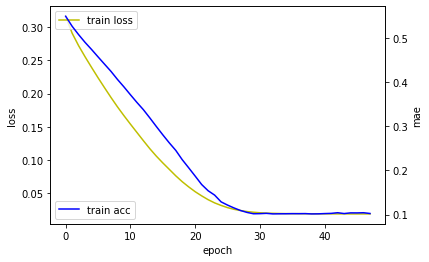

In [45]:
fig, loss_ax = plt.subplots()

acc_ax = loss_ax.twinx()

loss_ax.plot(hist1.history['loss'], 'y', label='train loss')

acc_ax.plot(hist1.history['mae'], 'b', label='train acc')

loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
acc_ax.set_ylabel('mae')

loss_ax.legend(loc='upper left')
acc_ax.legend(loc='lower left')

plt.show()

# 6. 성능확인

In [46]:
y_pred = model.predict(X_test_t)

In [47]:
y_check = pd.DataFrame({"y_pred":y_pred.reshape(-1), 
              "y":y_test_v.reshape(-1)})
y_check

,y_pred,y
0,0.540762,0.333333


In [48]:
rms = sqrt(mean_squared_error(y_test_v, y_pred))
rms

0.20742825667063397

In [114]:
# # HH
# hh2016 = model
# hh2016_pred = y_check
# hh2016_hist = hist1
# hh2016_rms = sqrt(mean_squared_error(y_test_v, y_pred))
# hh2016_pred

,y_pred,y
0,0.542638,0.5


In [89]:
# # LG
# lg2016 = model
# lg2016_pred = y_check
# lg2016_hist = hist1
# lg2016_rms = sqrt(mean_squared_error(y_test_v, y_pred))
lg2016_pred

,y_pred,y
0,0.555971,0.545455
